### Libraries

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

#pipa
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

#prepro
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
#model_select
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import RandomizedSearchCV
#model
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier

from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
#mblearn&sampling
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from imblearn.under_sampling import NearMiss
from imblearn.combine import SMOTETomek
from imblearn.combine import SMOTEENN
from imblearn.ensemble import EasyEnsembleClassifier
#metric
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import auc
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import average_precision_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix


from sklearn.base import clone
from scipy.stats import randint
from scipy.stats import uniform
import pickle
import shap


In [3]:
data=r"C:\Users\rafipriyahutama\OneDrive\Documents\Purwadhika\Module_three\capstone\dataset\Travel Insurance\data_travel_insurance.csv"
df=pd.read_csv(data)

In [4]:
df['Claim'].value_counts(normalize=True)*100

Claim
No     98.472749
Yes     1.527251
Name: proportion, dtype: float64

### Introduction

In [4]:
df.head()

,Agency,Agency Type,Distribution Channel,Product Name,Gender,Duration,Destination,Net Sales,Commision (in value),Age,Claim
0,C2B,Airlines,Online,Annual Silver Plan,F,365,SINGAPORE,216.0,54.0,57,No
1,EPX,Travel Agency,Online,Cancellation Plan,NaN,4,MALAYSIA,10.0,0.0,33,No
2,JZI,Airlines,Online,Basic Plan,M,19,INDIA,22.0,7.7,26,No
3,EPX,Travel Agency,Online,2 way Comprehensive Plan,NaN,20,UNITED STATES,112.0,0.0,59,No
4,C2B,Airlines,Online,Bronze Plan,M,8,SINGAPORE,16.0,4.0,28,No


In [6]:
df.columns

Index(['Agency', 'Agency Type', 'Distribution Channel', 'Product Name',
       'Gender', 'Duration', 'Destination', 'Net Sales',
       'Commision (in value)', 'Age', 'Claim'],
      dtype='object')

#### Context

Data ini berasal dari perushaan asuransi yang menyediakan produk-produk asuransi perjalaanan yang disalurkan melalui beberapa agen. Dari data yang didapat, diketahui bahwa 1,5% dari total customer melakukan claim, dan sisanya tidak.  

Dari data tersebut, perusahan asuransi ingin melakukan pengembangan operasional (termasuk optimalisasi harga dan efisiensi) dengan mengidentifikasi faktor-faktor signifikan apa yang membuat kustomer melakukan klaim asuransi perjalanan. Dengan melakukan identifikasi melalui machine learning, perusahaan dapat melakukan langkah proaktif sperti pengecekan resiko yang lebih baik, penyesuaian harga permi, dan langkah-langkah lain yang dapat menguntungkan perusahaan dalam jangka panjang  

#### Business Problem

Tanpa machine learning, perusahaan memperlakukan semua customer dengan cara sama (pun apabila dilakukan telah melakukan pemetaan, pemetaan dilakukan secara manual), hal ini menyebabkan:  

1. Tidak terdeteksinya high risk customer (false negative) yang berpotensi menyebabkan berkurangya keuntungan atau bahkan kerugian bagi perusahaan;  
2. Pengecekan resiko manual (mentreat semua faktor sama), selain berpotensi tidak akurat, juga memakan waktu sehingga menghambat operasional perusahaan;  
3. Tidak optimalnya pengecekan resiko. Karena mentreat semua faktor sama, perusahaan melakukan upaya berlebih yang sia-sia pada low risk customer (false positive).  


#### Goals

Perusahaan memerlukan pengecekan resiko yang berbasis data-driven untuk membantu early detection atas potential claimants.

Tujuan pembuatan model klasifikasi ini adalah untuk:  
1. Melakukan identifikasi dini untuk kustomer yang berpotensi untuk (likely to) membuat klaim;  
2. Meminimalisir tidak terdeteksinya kustomer yang secara potensial melakukan klaim (undetected claimants)(meminimalisir false negative);  
3. Menyediakan latar belakang pengetahuan bagi tim strategis dan tim terkait untuk melakukan langkah-langkah proaktif dalam mengelola resiko klaim asuransi perjalanan;  

Model ini akan membantu tim manajemen resiko untuk mengambil keputusan dan mengalokasi sumber daya perusahaan dengan lebih efisien dan akurat.  

#### Analytical Approach

1. Data Understanding & Cleaning
2. Exploratory Data Analysis (EDA)
3. Modeling
   a. Addressing Class Imbalance  
   b. Melatih beberapa model klasifikasi dengan hyper parameter default  
   c. memilih lima model terbaik  
   d. melakukan balancing dan setting class weight  
   f. memilih dua model terbaik  
   g. melakukan hyper parameter tuning untuk dua model terbaik  
   f. melatih dua model terbaik kepada data testing  
   e. evaluasi final dan memilih satu model terbaik  
4. Model Interpretation  
  a. menggunakan shap untuk melihat feature impact (faktor apa yang signifikan mendorong kustomer ke arah 1 (claim))  
5. Business Evaluation  
  a.membuat confusion matrix dan cost-benefit analysis.  


#### Stakeholders

1. Risk Management Team  
2. Underwriting Team  

#### Metric Selection

Metric menggunakan Recall:  

FN lebih merugikan daripada FP.

Bila FP banyak, perusahaan hanya akan kehilangan potential customer atau, kalau tidak ditolak, hanya kehilangan waktu karena harus melakukan verifikasi ekstra kepada kustomer yang sebenarnya low risk.  

Namun, apabila FN banyak, perusahaan berpotensi mengalami kerugian finansial yang besar karena tidak terdeteksinya orang yang berpotensi untuk melakukan klaim (high risk customer). 

Rumus Recall = TP / (TP + FN)
Recall sensitif terhadap FN, sehingga dengan memaksimalkan recall, diharapkan FN dapat diminimalisir.

#### 5 Point Business ML Goals (Summary)

1. Business Problem:  
Perusahaan kehilangan keuntungan (profit optimal) ketika kustomer yang berpotensi melakukan klaim tidak terdeteksi sejak awal.

2. Data:
Data berasal dari perusahaan asuransi yang memuat (durasi, produk yang dibeli, net values, destination, dll) dari kustomer yang membeli asuransi perjalanan. Data highly imbalanced dengan hanya 1.5% kustomer melakukan klaim.  

3. ML Objective:  
Membuat model klasifikasi yang mendapat nilai recall tinggi, tujuannya mengidentifikasi potential claimants secara lebih akurat.  

4. Action:  
Model klasifikasi akan digunakan oleh Managemen, Risk Management Team, dan Underwriting Team untuk:  
a) Melakukan identifikasi dini untuk kustomer yang berpotensi untuk membuat klaim;  
b) Melakukan readjustment premi asuransi untuk produk asuransi yang teridentifikasi beresiko melakukan klaim;  
c) Melakukan review ulang terhadap agen yang teridentifikasi melakukan banyak klaim berdasarkan data historis.  

5. Business Value:  
a) Mengurangi kerugian finansial akibat tidak terdeteksinya nasabah yang berpotensi melakukan klaim;  
b) Meningkatkan akurasi penilaian resiko dan strategi penetapan premi asuransi.;  
c) Meningkatkan efisiensi operasional melalui pengambilan keputusan berbasis data.  
d) Meningkatkan transparansi dalam pemantauan kinerja agen.  




### Data Understanding and EDA

#### Data Dictionary

Agensi: Nama agensi (pake kode)  
Agency Type: jenis agenis  
Distribution Channel: saluran distribus  
Product Name: nama produk asuransi  
Gender: jenis kelamin
Duration: Lama perjalanan  
Destination: Destinasi  
Net Sales: jumlalah penjualan atas satu produk asuransi perjalanan  
Commision (in value): nilai komisi yg diterima agen asuransi  
Age: Usia  
Claim: Status klaim (1 = klaim, 0 = tidak klaim)  


#### Checing Duplicated Data

In [7]:
df.duplicated().sum()

np.int64(4667)

In [8]:
df[df.duplicated(keep=False)].sort_values(by='Agency')

,Agency,Agency Type,Distribution Channel,Product Name,Gender,Duration,Destination,Net Sales,Commision (in value),Age,Claim
43985,ART,Airlines,Online,Value Plan,M,31,THAILAND,29.00,10.15,118,No
10217,ART,Airlines,Online,24 Protect,M,3,MALAYSIA,4.99,1.75,48,No
22009,ART,Airlines,Online,24 Protect,M,3,MALAYSIA,4.99,1.75,48,No
19436,ART,Airlines,Online,Value Plan,M,18,CHINA,61.00,21.35,118,No
31570,ART,Airlines,Online,Value Plan,M,18,CHINA,61.00,21.35,118,No
...,...,...,...,...,...,...,...,...,...,...,...
2008,TTW,Travel Agency,Offline,Child Comprehensive Plan,M,369,SINGAPORE,74.00,0.00,9,No
29771,TTW,Travel Agency,Offline,Individual Comprehensive Plan,M,364,SINGAPORE,97.00,0.00,42,No
10520,TTW,Travel Agency,Offline,Individual Comprehensive Plan,M,364,SINGAPORE,97.00,0.00,33,No
23563,TTW,Travel Agency,Offline,Individual Comprehensive Plan,M,364,SINGAPORE,97.00,0.00,42,No


In [9]:
#percantage of duplicated data
df.duplicated().sum()/len(df)*100

np.float64(10.528334235697526)

In [10]:
#dropping duplicated data
df.drop_duplicates(inplace=True)

In [11]:
df.duplicated().sum()

np.int64(0)

#### Checking missing values in gender

In [12]:
df['Gender'].isna().sum()/len(df)*100

np.float64(69.75870502508762)

Ada 71% data hilang pada kolom Gender. Dengan demikian, strategi imputasi dengan modus tidak dapat dijustifikasi (nilai mayoritas hilang). Karena itu saya, akan menghapus kolom in.  

In [13]:
df.drop(columns=['Gender'],inplace=True)

In [14]:
df.columns

Index(['Agency', 'Agency Type', 'Distribution Channel', 'Product Name',
       'Duration', 'Destination', 'Net Sales', 'Commision (in value)', 'Age',
       'Claim'],
      dtype='object')

In [15]:
df.columns

Index(['Agency', 'Agency Type', 'Distribution Channel', 'Product Name',
       'Duration', 'Destination', 'Net Sales', 'Commision (in value)', 'Age',
       'Claim'],
      dtype='object')

#### Handling Product Name

In [16]:
df['Agency Type'].unique()

array(['Airlines', 'Travel Agency'], dtype=object)

In [17]:
df['Product Name'].unique()

array(['Annual Silver Plan', 'Cancellation Plan', 'Basic Plan',
       '2 way Comprehensive Plan', 'Bronze Plan',
       '1 way Comprehensive Plan', 'Rental Vehicle Excess Insurance',
       'Single Trip Travel Protect Gold', 'Silver Plan', 'Value Plan',
       '24 Protect', 'Annual Travel Protect Gold', 'Comprehensive Plan',
       'Ticket Protector', 'Travel Cruise Protect',
       'Single Trip Travel Protect Silver',
       'Individual Comprehensive Plan', 'Gold Plan', 'Annual Gold Plan',
       'Child Comprehensive Plan', 'Premier Plan',
       'Annual Travel Protect Silver',
       'Single Trip Travel Protect Platinum',
       'Annual Travel Protect Platinum',
       'Spouse or Parents Comprehensive Plan',
       'Travel Cruise Protect Family'], dtype=object)

Product Category Mapping Description:  
1. Comperhensive: Paket perlindungan perjalanan lengkap yang mengcover seperti pembatalan, emergensi medis, kehilangan bagasi, dan resiko perjalanan lain.  
2. Annual: Paket asuransi perjalanan tahunan yang dirancang untuk orang yang sering bepergian (frequent travelers). Terdapat berbagai tier dalam paket ini.  
3. Single Trip: Paket asuransi untuk perjalanan short duration  
4. Value Plan: Paket asuransi berdasarkan trip-level tiered  
5. Cancellation: Paket asuransi yang mengcover pembatalan perjalanan  
6. Rental: Paket asuransi yang mengcover rental (peminjaman kendaraan)

In [18]:
df.groupby('Agency Type')['Product Name'].nunique()

Agency Type
Airlines         10
Travel Agency    18
Name: Product Name, dtype: int64

In [19]:
df.groupby('Agency')['Product Name'].nunique()

Agency
ADM    2
ART    2
C2B    5
CBH    2
CCR    2
CSR    2
CWT    1
EPX    3
JWT    1
JZI    3
KML    2
LWC    6
RAB    1
SSI    1
TST    2
TTW    3
Name: Product Name, dtype: int64

In [20]:
df['Product Name'].value_counts()

Product Name
Cancellation Plan                       11009
2 way Comprehensive Plan                 8133
Rental Vehicle Excess Insurance          5726
Basic Plan                               3692
Bronze Plan                              2718
1 way Comprehensive Plan                 1848
Value Plan                               1647
Silver Plan                              1504
Annual Silver Plan                        897
Ticket Protector                          711
Travel Cruise Protect                     342
Comprehensive Plan                        245
Gold Plan                                 236
24 Protect                                171
Annual Gold Plan                          138
Single Trip Travel Protect Gold           134
Premier Plan                              124
Single Trip Travel Protect Silver         116
Annual Travel Protect Gold                 63
Annual Travel Protect Silver               59
Single Trip Travel Protect Platinum        47
Individual Comprehens

Di sini ada permasalahan dengan product name. ia memiliki 26 unique values. Secara teknis, bila menggunakan one hot, tentu akan memperlambat kerja model; bila menggunkan binary, maka kolom ini tidak bisa diinterpretasi. Solusinya ada dua: (1) mengubahnya menjadi prosentase numerik dengan membandingkannya dengan claim dan membuat kolom baru yang berisi product claim rate (prosentase customer yang membeli product X untuk melakukan claim); (2) mengelompokkan product name berdasarkan karakterisitik produknya.  

Saya memilih opsi (2) karena alasan interpretabilitas, generalisasi dan kegunaan bisnis. Bila saya memilih opsi (1), fitur tersebut menjai sulit dinterpretasi karena saya harus mengecek kembali prosentase terkait merepresentasi produk apa. Selain itu, angka-angka itu juga tidak bisa digeneralisasi ke prouduk baru yang mungkin muncul di masa depan.  

In [21]:
mapping = {
    # Comprehensive
    '1 way Comprehensive Plan': 'Comprehensive',
    '2 way Comprehensive Plan': 'Comprehensive',
    'Individual Comprehensive Plan': 'Comprehensive',
    'Spouse or Parents Comprehensive Plan': 'Comprehensive',
    'Comprehensive Plan': 'Comprehensive',
    'Child Comprehensive Plan': 'Comprehensive',

    # Annual
    'Annual Gold Plan': 'Annual',
    'Annual Silver Plan': 'Annual',
    'Annual Travel Protect Gold': 'Annual',
    'Annual Travel Protect Silver': 'Annual',
    'Annual Travel Protect Platinum': 'Annual',
    '24 Protect': 'Annual',

    # Single Trip
    'Single Trip Travel Protect Gold': 'Single Trip',
    'Single Trip Travel Protect Silver': 'Single Trip',
    'Single Trip Travel Protect Platinum': 'Single Trip',
    'Travel Cruise Protect': 'Single Trip',
    'Travel Cruise Protect Family': 'Single Trip',

    # Value Plan
    'Basic Plan': 'Value Plan',
    'Value Plan': 'Value Plan',
    'Gold Plan': 'Value Plan',
    'Silver Plan': 'Value Plan',
    'Bronze Plan': 'Value Plan',
    'Premier Plan': 'Value Plan',

    # Cancellation
    'Cancellation Plan': 'Cancellation',
    'Ticket Protector': 'Cancellation',

    # Rental
    'Rental Vehicle Excess Insurance': 'Rental'
}

df['Product_Category'] = df['Product Name'].map(mapping)
df = df.drop(columns=['Product Name'])


In [22]:
df['Product_Category'].value_counts()

Product_Category
Cancellation     11720
Comprehensive    10292
Value Plan        9921
Rental            5726
Annual            1362
Single Trip        640
Name: count, dtype: int64

#### Handling Agency

In [23]:
df['Agency'].value_counts()

Agency
EPX    20990
CWT     5726
C2B     5493
JZI     4288
SSI      711
RAB      469
LWC      453
TST      343
JWT      337
KML      249
ART      226
CCR      118
CBH       69
CSR       68
TTW       66
ADM       55
Name: count, dtype: int64

In [24]:
pd.crosstab(df['Agency Type'], df['Claim'], normalize='index')


Claim,No,Yes
Agency Type,,
Airlines,0.962079,0.037921
Travel Agency,0.991541,0.008459


#### Checking Claim Imbalance

In [25]:
#value in percentage
df['Claim'].value_counts(normalize=True) * 100

Claim
No     98.298076
Yes     1.701924
Name: proportion, dtype: float64

#### Handling Age Data

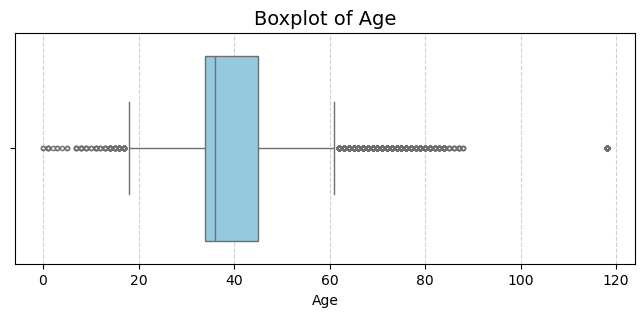

In [26]:
plt.figure(figsize=(8, 3))
sns.boxplot(x=df['Age'], color='skyblue', fliersize=3, linewidth=1)

plt.title('Boxplot of Age', fontsize=14)
plt.xlabel('Age')
plt.grid(axis='x', linestyle='--', alpha=0.6)
plt.show()

In [27]:
umur=df['Age'].describe()
umur

count    39661.000000
mean        39.930284
std         13.526346
min          0.000000
25%         34.000000
50%         36.000000
75%         45.000000
max        118.000000
Name: Age, dtype: float64

In [28]:
# Count how many rows have Age = 0
zero_age_count = (df['Age'] == 0).sum()
print(f"Number of customers with Age = 0: {zero_age_count}")


Number of customers with Age = 0: 2


In [29]:
df.drop(df[df['Age'] == 0].index, inplace=True)

In [30]:
zero_age_count = (df['Age'] == 0).sum()
print(f"Number of customers with Age = 0: {zero_age_count}")

Number of customers with Age = 0: 0


#### Handling Destination

In [31]:
df['Destination'].unique()

array(['SINGAPORE', 'MALAYSIA', 'INDIA', 'UNITED STATES',
       'KOREA, REPUBLIC OF', 'THAILAND', 'GERMANY', 'JAPAN', 'INDONESIA',
       'VIET NAM', 'AUSTRALIA', 'FINLAND', 'UNITED KINGDOM', 'SRI LANKA',
       'SPAIN', 'HONG KONG', 'MACAO', 'CHINA', 'UNITED ARAB EMIRATES',
       'IRAN, ISLAMIC REPUBLIC OF', 'TAIWAN, PROVINCE OF CHINA', 'POLAND',
       'CANADA', 'OMAN', 'PHILIPPINES', 'GREECE', 'BELGIUM', 'TURKEY',
       'BRUNEI DARUSSALAM', 'DENMARK', 'SWITZERLAND', 'NETHERLANDS',
       'SWEDEN', 'MYANMAR', 'KENYA', 'CZECH REPUBLIC', 'FRANCE',
       'RUSSIAN FEDERATION', 'PAKISTAN', 'ARGENTINA',
       'TANZANIA, UNITED REPUBLIC OF', 'SERBIA', 'ITALY', 'CROATIA',
       'NEW ZEALAND', 'PERU', 'MONGOLIA', 'CAMBODIA', 'QATAR', 'NORWAY',
       'LUXEMBOURG', 'MALTA', "LAO PEOPLE'S DEMOCRATIC REPUBLIC",
       'ISRAEL', 'SAUDI ARABIA', 'AUSTRIA', 'PORTUGAL', 'NEPAL',
       'UKRAINE', 'ESTONIA', 'ICELAND', 'BRAZIL', 'MEXICO',
       'CAYMAN ISLANDS', 'PANAMA', 'BANGLADESH', 'TURKME

In [32]:
country_to_continent = {
    #Asia
    'SINGAPORE': 'Asia', 'MALAYSIA': 'Asia', 'INDIA': 'Asia', 'KOREA, REPUBLIC OF': 'Asia',
    'THAILAND': 'Asia', 'JAPAN': 'Asia', 'INDONESIA': 'Asia', 'VIET NAM': 'Asia',
    'SRI LANKA': 'Asia', 'HONG KONG': 'Asia', 'MACAO': 'Asia', 'CHINA': 'Asia',
    'UNITED ARAB EMIRATES': 'Asia', 'IRAN, ISLAMIC REPUBLIC OF': 'Asia',
    'TAIWAN, PROVINCE OF CHINA': 'Asia', 'OMAN': 'Asia', 'PHILIPPINES': 'Asia',
    'BRUNEI DARUSSALAM': 'Asia', 'MYANMAR': 'Asia', 'PAKISTAN': 'Asia', 'MONGOLIA': 'Asia',
    'CAMBODIA': 'Asia', 'QATAR': 'Asia', "LAO PEOPLE'S DEMOCRATIC REPUBLIC": 'Asia',
    'ISRAEL': 'Asia', 'SAUDI ARABIA': 'Asia', 'NEPAL': 'Asia', 'BANGLADESH': 'Asia',
    'TURKMENISTAN': 'Asia', 'BAHRAIN': 'Asia', 'KAZAKHSTAN': 'Asia', 'MALDIVES': 'Asia',
    'JORDAN': 'Asia', 'CYPRUS': 'Asia', 'LEBANON': 'Asia', 'KUWAIT': 'Asia', 'AZERBAIJAN': 'Asia',
    'BHUTAN': 'Asia', 'UZBEKISTAN': 'Asia', 'PAPUA NEW GUINEA': 'Oceania',
    'ARMENIA': 'Asia', "KOREA, DEMOCRATIC PEOPLE'S REPUBLIC OF": 'Asia', 'TAJIKISTAN': 'Asia',
    'GEORGIA': 'Asia', 'KYRGYZSTAN': 'Asia', 'TIBET': 'Asia','TURKEY': 'Asia',

    # Europe
    'GERMANY': 'Europe', 'FINLAND': 'Europe', 'UNITED KINGDOM': 'Europe', 'SPAIN': 'Europe',
    'POLAND': 'Europe', 'GREECE': 'Europe', 'BELGIUM': 'Europe', 'DENMARK': 'Europe',
    'SWITZERLAND': 'Europe', 'NETHERLANDS': 'Europe', 'SWEDEN': 'Europe',
    'CZECH REPUBLIC': 'Europe', 'FRANCE': 'Europe', 'SERBIA': 'Europe', 'ITALY': 'Europe',
    'CROATIA': 'Europe', 'NORWAY': 'Europe', 'LUXEMBOURG': 'Europe', 'MALTA': 'Europe',
    'AUSTRIA': 'Europe', 'PORTUGAL': 'Europe', 'UKRAINE': 'Europe', 'ESTONIA': 'Europe',
    'ICELAND': 'Europe', 'IRELAND': 'Europe', 'HUNGARY': 'Europe', 'BELARUS': 'Europe',
    'MACEDONIA, THE FORMER YUGOSLAV REPUBLIC OF': 'Europe', 'SLOVENIA': 'Europe',
    'BULGARIA': 'Europe', 'ROMANIA': 'Europe', 'REPUBLIC OF MONTENEGRO': 'Europe',
    'LITHUANIA': 'Europe', 'LATVIA': 'Europe', 'FAROE ISLANDS': 'Europe',
    'MOLDOVA, REPUBLIC OF': 'Europe', 'REUNION': 'Europe','RUSSIAN FEDERATION': 'Europe',

    # North America

    'UNITED STATES':'North America', 'CANADA': 'North America', 'MEXICO': 'North America',
    'CAYMAN ISLANDS': 'North America', 'PANAMA': 'North America',
    'NORTHERN MARIANA ISLANDS': 'North America', 'GUAM': 'North America',
    'PUERTO RICO': 'North America', 'BERMUDA': 'North America',
    'TRINIDAD AND TOBAGO': 'North America',

    # South America
    'ARGENTINA': 'South America', 'BRAZIL': 'South America', 'PERU': 'South America',
    'VENEZUELA': 'South America', 'COSTA RICA': 'South America', 'ECUADOR': 'South America',
    'CHILE': 'South America', 'COLOMBIA': 'South America', 'URUGUAY': 'South America',
    'BOLIVIA': 'South America', 'GUYANA': 'South America', 'DOMINICAN REPUBLIC': 'South America', 'JAMAICA': 'North America', 'GUADELOUPE': 'North America',

    # Africa
    'KENYA': 'Africa', 'TANZANIA, UNITED REPUBLIC OF': 'Africa', 'MALI': 'Africa',
    'ETHIOPIA': 'Africa', 'SOUTH AFRICA': 'Africa', 'MAURITIUS': 'Africa', 'MOROCCO': 'Africa',
    'TUNISIA': 'Africa', 'ANGOLA': 'Africa', 'NIGERIA': 'Africa', 'NAMIBIA': 'Africa',
    'EGYPT': 'Africa', 'ZIMBABWE': 'Africa', 'GUINEA': 'Africa', 'GHANA': 'Africa',
    'UGANDA': 'Africa', 'ZAMBIA': 'Africa', 'RWANDA': 'Africa', 'BOTSWANA': 'Africa',
    'GUINEA-BISSAU': 'Africa', 'SENEGAL': 'Africa', 'CAMEROON': 'Africa', 'BENIN': 'Africa',

    # Oceania
    'AUSTRALIA': 'Oceania', 'NEW ZEALAND': 'Oceania', 'FIJI': 'Oceania',
    'FRENCH POLYNESIA': 'Oceania', 'VANUATU': 'Oceania', 'SAMOA': 'Oceania',
}

df['Destination'] = df['Destination'].replace(country_to_continent)


In [33]:
df['Destination'].unique()

array(['Asia', 'North America', 'Europe', 'Oceania', 'Africa',
       'South America'], dtype=object)

In [34]:
df.columns

Index(['Agency', 'Agency Type', 'Distribution Channel', 'Duration',
       'Destination', 'Net Sales', 'Commision (in value)', 'Age', 'Claim',
       'Product_Category'],
      dtype='object')

#### Net Sales Anomaly

In [35]:
#net sales below 0 percantage
df[df['Net Sales'] < 0].value_counts().sum()/len(df)*100

np.float64(1.2027534733603973)

In [36]:
df.drop(df[df['Net Sales'] < 0].index, inplace=True)

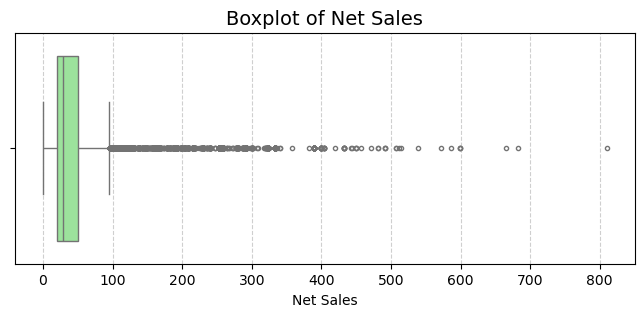

In [37]:
#net sales boxplot
plt.figure(figsize=(8, 3))
sns.boxplot(x=df['Net Sales'], color='lightgreen', fliersize=3, linewidth=1)
plt.title('Boxplot of Net Sales', fontsize=14)
plt.xlabel('Net Sales')
plt.grid(axis='x', linestyle='--', alpha=0.6)
plt.show()

#### Checking Duration anomaly

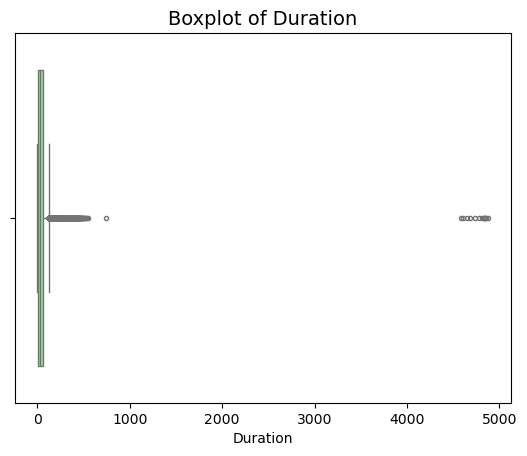

In [38]:
sns.boxplot(x=df['Duration'], color='lightgreen', fliersize=3, linewidth=1)
plt.title('Boxplot of Duration', fontsize=14)
plt.show()

In [39]:
df['Duration'].describe()

count    39182.000000
mean        52.086494
std        113.881050
min         -1.000000
25%         10.000000
50%         24.000000
75%         56.000000
max       4881.000000
Name: Duration, dtype: float64

In [40]:
#minus 0
cekdurasi=df[df['Duration'] < 1]
cekdurasi

,Agency,Agency Type,Distribution Channel,Duration,Destination,Net Sales,Commision (in value),Age,Claim,Product_Category
242,JZI,Airlines,Online,0,Asia,22.00,7.70,34,No,Value Plan
1782,SSI,Airlines,Online,0,Asia,1.80,0.50,48,No,Cancellation
1853,JWT,Airlines,Online,0,Asia,62.00,24.80,118,No,Value Plan
2558,SSI,Airlines,Online,0,Asia,9.77,2.74,48,No,Cancellation
3236,LWC,Travel Agency,Online,0,Asia,35.25,22.91,24,No,Single Trip
3406,SSI,Airlines,Online,0,Asia,2.86,0.80,48,No,Cancellation
3549,JZI,Airlines,Online,0,Asia,18.00,6.30,58,No,Value Plan
3591,JZI,Airlines,Online,0,Asia,18.00,6.30,26,No,Value Plan
3753,JWT,Airlines,Online,0,Asia,31.00,12.40,118,No,Value Plan
4939,CWT,Travel Agency,Online,0,North America,9.90,5.94,59,No,Rental


Berdasarkan domain knowledge, diketahui bahwa durasi perjalanan selalu dihitung berdasarkan hari. Pun bila kategori produk yang dibeli adalah cancellation, durasi perjalanan tetap dihitung berdasarkan durasi perjalanan yang akan dicover. Oleh karena itu, durasi perjalanan tidak mungkin bernilai negatif atau nol.

In [41]:
df.drop(df[df['Duration'] < 1].index, inplace=True)


In [42]:
# Calculate Q1, Q2, Q3, and IQR for 'Duration'
Q1 = df['Duration'].quantile(0.25)
Q2 = df['Duration'].quantile(0.5)
Q3 = df['Duration'].quantile(0.75)
IQR = Q3 - Q1

# Define bounds for outlier detection
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Count outliers
outliers = df[(df['Duration'] < lower_bound) | (df['Duration'] > upper_bound)]

# formatted output
print("Duration Statistics".center(50, "-"))
print(f"Q1 (25th percentile) : {Q1:.2f}")
print(f"Q2 (Median)           : {Q2:.2f}")
print(f"Q3 (75th percentile)  : {Q3:.2f}")
print(f"IQR (Q3 - Q1)         : {IQR:.2f}")
print(f"Lower Bound (Q1 - 1.5*IQR) : {lower_bound:.2f}")
print(f"Upper Bound (Q3 + 1.5*IQR) : {upper_bound:.2f}")
print(f"Potential Outliers (> {upper_bound:.2f}) : {len(outliers)} records")
print("-" * 50)


---------------Duration Statistics----------------
Q1 (25th percentile) : 10.00
Q2 (Median)           : 24.00
Q3 (75th percentile)  : 56.00
IQR (Q3 - Q1)         : 46.00
Lower Bound (Q1 - 1.5*IQR) : -59.00
Upper Bound (Q3 + 1.5*IQR) : 125.00
Potential Outliers (> 125.00) : 3434 records
--------------------------------------------------


In [43]:
total_rows = len(df)
outlier_count = len(outliers)
outlier_percentage = (outlier_count / total_rows) * 100
print(f"total rows: {total_rows}")
print(f"outlier count: {outlier_count}")
print(f"outlier percentage: {outlier_percentage:.2f}%")

total rows: 39144
outlier count: 3434
outlier percentage: 8.77%


In [44]:
df[df['Duration'] > 365][['Product_Category', 'Duration', 'Claim']].sort_values(by='Duration', ascending=False)


,Product_Category,Duration,Claim
19497,Cancellation,4881,No
4678,Cancellation,4857,No
42717,Cancellation,4847,No
20038,Cancellation,4844,No
42584,Cancellation,4831,No
...,...,...,...
42491,Annual,366,No
4153,Annual,366,No
42579,Annual,366,No
43346,Annual,366,No


In [45]:
total_rows = len(df)
above_365 = len(df[df['Duration'] > 365])
percentage_above_365 = (above_365 / total_rows) * 100

print("-------- Duration > 365 Days Check --------")
print(f"Total rows: {total_rows}")
print(f"Rows with Duration > 365 days: {above_365}")
print(f"Percentage: {percentage_above_365:.2f}%")



-------- Duration > 365 Days Check --------
Total rows: 39144
Rows with Duration > 365 days: 884
Percentage: 2.26%


Selain durasi minus dan 0, ada beberapa anomali durasi perjalanan. Dari slicing di atas, dapat dilihat bahwa ada beberapa durasi perjalanan yang sangat panjang dan tidak masuk akal, misalnya 4500 hari.  

 Selain itu, terlihat juga beberapa anomali terkait durasi perjalanan yang dicover oleh asuransi. Dari hasil penyelidikan ke beberapa firma asuransi, durasi terbanyak yang bisa dicover dalam satu paket adalah 365 hari, bahkan ada perusahan yang hanya menjual lebih pendek, yaitu 3 bulan.  
 
 Menimbang prosentasenya yang sedikit, hanya 2%  dari total data. saya akan menghapus data dengan durasi di atas 365 hari dan melakukan binning untuk memudahkan interpretasi.  

In [46]:
df.drop(df[df['Duration'] > 365].index, inplace=True)


#### Last Checking

In [47]:
df.columns

Index(['Agency', 'Agency Type', 'Distribution Channel', 'Duration',
       'Destination', 'Net Sales', 'Commision (in value)', 'Age', 'Claim',
       'Product_Category'],
      dtype='object')

In [48]:
df.head()

,Agency,Agency Type,Distribution Channel,Duration,Destination,Net Sales,Commision (in value),Age,Claim,Product_Category
0,C2B,Airlines,Online,365,Asia,216.0,54.0,57,No,Annual
1,EPX,Travel Agency,Online,4,Asia,10.0,0.0,33,No,Cancellation
2,JZI,Airlines,Online,19,Asia,22.0,7.7,26,No,Value Plan
3,EPX,Travel Agency,Online,20,North America,112.0,0.0,59,No,Comprehensive
4,C2B,Airlines,Online,8,Asia,16.0,4.0,28,No,Value Plan


In [49]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 38260 entries, 0 to 44327
Data columns (total 10 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Agency                38260 non-null  object 
 1   Agency Type           38260 non-null  object 
 2   Distribution Channel  38260 non-null  object 
 3   Duration              38260 non-null  int64  
 4   Destination           38260 non-null  object 
 5   Net Sales             38260 non-null  float64
 6   Commision (in value)  38260 non-null  float64
 7   Age                   38260 non-null  int64  
 8   Claim                 38260 non-null  object 
 9   Product_Category      38260 non-null  object 
dtypes: float64(2), int64(2), object(6)
memory usage: 3.2+ MB


In [50]:
#checking missing value
df.isna().sum()

Agency                  0
Agency Type             0
Distribution Channel    0
Duration                0
Destination             0
Net Sales               0
Commision (in value)    0
Age                     0
Claim                   0
Product_Category        0
dtype: int64

In [51]:
#precentage yes an no
df['Claim'].value_counts(normalize=True) * 100

Claim
No     98.473602
Yes     1.526398
Name: proportion, dtype: float64

In [54]:
df.reset_index(drop=True)

,Agency,Agency Type,Distribution Channel,Duration,Destination,Net Sales,Commision (in value),Age,Claim,Product_Category
0,C2B,Airlines,Online,365,Asia,216.0,54.00,57,No,Annual
1,EPX,Travel Agency,Online,4,Asia,10.0,0.00,33,No,Cancellation
2,JZI,Airlines,Online,19,Asia,22.0,7.70,26,No,Value Plan
3,EPX,Travel Agency,Online,20,North America,112.0,0.00,59,No,Comprehensive
4,C2B,Airlines,Online,8,Asia,16.0,4.00,28,No,Value Plan
...,...,...,...,...,...,...,...,...,...,...
38255,EPX,Travel Agency,Online,14,Asia,30.0,0.00,36,Yes,Comprehensive
38256,CWT,Travel Agency,Online,17,Oceania,79.2,47.52,47,No,Rental
38257,TST,Travel Agency,Offline,64,Asia,30.0,10.50,50,No,Single Trip
38258,EPX,Travel Agency,Online,51,Asia,36.0,0.00,36,No,Comprehensive


In [56]:
df = df.dropna(how='all').reset_index(drop=True)

In [57]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38260 entries, 0 to 38259
Data columns (total 10 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Agency                38260 non-null  object 
 1   Agency Type           38260 non-null  object 
 2   Distribution Channel  38260 non-null  object 
 3   Duration              38260 non-null  int64  
 4   Destination           38260 non-null  object 
 5   Net Sales             38260 non-null  float64
 6   Commision (in value)  38260 non-null  float64
 7   Age                   38260 non-null  int64  
 8   Claim                 38260 non-null  object 
 9   Product_Category      38260 non-null  object 
dtypes: float64(2), int64(2), object(6)
memory usage: 2.9+ MB


In [58]:
df['Claim'] = (
    df['Claim']
    .str.strip()           # remove spaces
    .str.capitalize()      # normalize case
    .map({'Yes': 1, 'No': 0})
)

In [59]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38260 entries, 0 to 38259
Data columns (total 10 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Agency                38260 non-null  object 
 1   Agency Type           38260 non-null  object 
 2   Distribution Channel  38260 non-null  object 
 3   Duration              38260 non-null  int64  
 4   Destination           38260 non-null  object 
 5   Net Sales             38260 non-null  float64
 6   Commision (in value)  38260 non-null  float64
 7   Age                   38260 non-null  int64  
 8   Claim                 38260 non-null  int64  
 9   Product_Category      38260 non-null  object 
dtypes: float64(2), int64(3), object(5)
memory usage: 2.9+ MB


In [60]:
(df['Claim'].value_counts(normalize=True) * 100).round(2)

Claim
0    98.47
1     1.53
Name: proportion, dtype: float64

In [61]:
print("Rows in DataFrame:", len(df))
print("Max index:", df.index.max())

Rows in DataFrame: 38260
Max index: 38259


In [ ]:
#save data
#df.to_csv(r"C:\Users\rafipriyahutama\OneDrive\Documents\Purwadhika\Module_three\capstone\dataset\Travel Insurance\data_travel_bersih_banget.csv", index=False)

### Modeling

#### Splitting

In [5]:
data=r"C:\Users\rafipriyahutama\OneDrive\Documents\Purwadhika\Module_three\capstone\dataset\Travel Insurance\data_travel_bersih_banget.csv"
df_cleaned=pd.read_csv(data)
df_cleaned.head()

,Agency,Agency Type,Distribution Channel,Duration,Destination,Net Sales,Commision (in value),Age,Claim,Product_Category
0,C2B,Airlines,Online,365,Asia,216.0,54.0,57,0,Annual
1,EPX,Travel Agency,Online,4,Asia,10.0,0.0,33,0,Cancellation
2,JZI,Airlines,Online,19,Asia,22.0,7.7,26,0,Value Plan
3,EPX,Travel Agency,Online,20,North America,112.0,0.0,59,0,Comprehensive
4,C2B,Airlines,Online,8,Asia,16.0,4.0,28,0,Value Plan


In [6]:
X=df_cleaned.drop(columns=['Claim'])
y=df_cleaned['Claim']

In [7]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

In [8]:
print(f"Train size: {len(X_train)}, Test size: {len(X_test)}")
print("Class distribution (train):")
print(y_train.value_counts(normalize=True))

Train size: 30608, Test size: 7652
Class distribution (train):
Claim
0    0.984743
1    0.015257
Name: proportion, dtype: float64


In [9]:
numerical_features = X_train.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_features = X_train.select_dtypes(include=['object', 'category']).columns.tolist()
print("Numeric:", numerical_features)
print("One-hot:", categorical_features)

Numeric: ['Duration', 'Net Sales', 'Commision (in value)', 'Age']
One-hot: ['Agency', 'Agency Type', 'Distribution Channel', 'Destination', 'Product_Category']


#### Prepo Pipeline

In [10]:
from sklearn.impute import SimpleImputer

In [11]:
num_imputer = SimpleImputer(strategy='median')
cat_imputer = SimpleImputer(strategy='most_frequent')

num_scaler = RobustScaler()
cat_encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)

In [12]:
pre_no_scaling = ColumnTransformer([
    ('num', Pipeline([('imputer', num_imputer)]), numerical_features),
    ('cat', Pipeline([('imputer', cat_imputer), ('onehot', cat_encoder)]), categorical_features)
], remainder='drop')

pre_scaling = ColumnTransformer([
    ('num', Pipeline([('imputer', num_imputer), ('scaler', num_scaler)]), numerical_features),
    ('cat', Pipeline([('imputer', cat_imputer), ('onehot', cat_encoder)]), categorical_features)
], remainder='drop')

#### Model Pipeline

In [36]:
models = {
    'Logistic Regression': LogisticRegression(random_state=42),
    'KNN': KNeighborsClassifier(n_neighbors=5),
    'Decision Tree': DecisionTreeClassifier(random_state=42),
    'Random Forest': RandomForestClassifier(random_state=42),
    'Gradient Boosting': GradientBoostingClassifier(random_state=42),
    'AdaBoost': AdaBoostClassifier(random_state=42),
    'CatBoost': CatBoostClassifier(random_state=42),
    'LightGBM': LGBMClassifier(random_state=42),
    'XGBoost': XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42),
    'EasyEnsembleClassifier': EasyEnsembleClassifier(random_state=42)
    
}
scaling_models = ['Logistic Regression', 'KNN']

#### Model Fitting (base selection)

In [38]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scoring = 'recall'

results = []

for name, model in models.items():
    preprocessor = pre_scaling if name in scaling_models else pre_no_scaling

    pipe = Pipeline([
        ('preprocessor', preprocessor),
        ('model', model)
    ])

    print(f"\nEvaluating {name} ...")
    scores = cross_val_score(pipe, X_train, y_train, scoring=scoring, cv=cv, n_jobs=-1)
    results.append({
        'Model': name,
        'Recall_mean': np.mean(scores),
        'Recall_std': np.std(scores)
    })
    print(f"Recall (CV 5-fold): {np.mean(scores):.4f} ± {np.std(scores):.4f}")

# Leaderboard
results_df = pd.DataFrame(results).sort_values(by='Recall_mean', ascending=False)
print("\n=== BASELINE MODEL LEADERBOARD (by Recall) ===")
print(results_df)


Evaluating Logistic Regression ...
Recall (CV 5-fold): 0.0000 ± 0.0000

Evaluating KNN ...
Recall (CV 5-fold): 0.0043 ± 0.0052

Evaluating Decision Tree ...
Recall (CV 5-fold): 0.0429 ± 0.0098

Evaluating Random Forest ...
Recall (CV 5-fold): 0.0107 ± 0.0117

Evaluating Gradient Boosting ...
Recall (CV 5-fold): 0.0000 ± 0.0000

Evaluating AdaBoost ...
Recall (CV 5-fold): 0.0000 ± 0.0000

Evaluating CatBoost ...
Recall (CV 5-fold): 0.0043 ± 0.0052

Evaluating LightGBM ...
Recall (CV 5-fold): 0.0000 ± 0.0000

Evaluating XGBoost ...
Recall (CV 5-fold): 0.0021 ± 0.0043

Evaluating EasyEnsembleClassifier ...
Recall (CV 5-fold): 0.6510 ± 0.0606

=== BASELINE MODEL LEADERBOARD (by Recall) ===
                    Model  Recall_mean  Recall_std
9  EasyEnsembleClassifier     0.650995    0.060596
2           Decision Tree     0.042873    0.009771
3           Random Forest     0.010684    0.011654
6                CatBoost     0.004278    0.005240
1                     KNN     0.004255    0.00521

Ambil top six (penasaran nyoba xgboost):  
1. Easy Ensemble 
2. Decision Tree 
3. Random Forest
4. Catboost
5. KNN
6. XG Boost  

#### Model Resampling and penalized

In [41]:
resamplers = {
    'RUS': RandomUnderSampler(random_state=42),                    
    'SMOTE': SMOTE(random_state=42),                               
    'SMOTETomek': SMOTETomek(random_state=42),                     
    'SMOTEENN': SMOTEENN(random_state=42) ,                            
}

In [42]:
models = {
    'Decision Tree': DecisionTreeClassifier(random_state=42),
    'Random Forest': RandomForestClassifier(n_estimators=200, random_state=42),
    'CatBoost': CatBoostClassifier(verbose=0, random_state=42),
    'KNN': KNeighborsClassifier(n_neighbors=5),
    'XGBoost': XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42),
    'EasyEnsembleClassifier': EasyEnsembleClassifier(random_state=42)
}
scaling_models = ['KNN']

In [ ]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scoring = 'recall'

results = []


for name, model in models.items():
    print(f"\n==============================")
    print(f"Model: {name}")
    print("==============================")

    # select appropriate preprocessor
    preprocessor = pre_scaling if name in scaling_models else pre_no_scaling

    # Cek ulang baseline buat komparasi
    pipe_base = ImbPipeline([
        ('preprocessor', preprocessor),
        ('model', clone(model))
    ])

    base_scores = cross_val_score(pipe_base, X_train, y_train, scoring=scoring, cv=cv, n_jobs=-1)
    results.append({'Model': name, 'Strategy': 'Baseline', 'Recall_mean': base_scores.mean(), 'Recall_std': base_scores.std()})
    print(f"Baseline Recall: {base_scores.mean():.4f} ± {base_scores.std():.4f}")

    # Ngetes penalized model
    penal_model = clone(model)
    penalized_applied = False

    if hasattr(penal_model, 'class_weight'):
        penal_model.set_params(class_weight='balanced')
        penalized_applied = True

    if name == 'XGBoost':
        
        ratio = int((y_train == 0).sum() / (y_train == 1).sum())
        penal_model.set_params(scale_pos_weight=ratio)
        penalized_applied = True
    if name == 'CatBoost':
        penal_model.set_params(auto_class_weights='Balanced')
        penalized_applied = True

    if penalized_applied:
        pipe_pen = ImbPipeline([
            ('preprocessor', preprocessor),
            ('model', penal_model)
        ])
        pen_scores = cross_val_score(pipe_pen, X_train, y_train, scoring=scoring, cv=cv, n_jobs=-1)
        results.append({'Model': name, 'Strategy': 'Penalized', 'Recall_mean': pen_scores.mean(), 'Recall_std': pen_scores.std()})
        print(f"Penalized Recall: {pen_scores.mean():.4f} ± {pen_scores.std():.4f}")

    # Resampling
    for sampler_name, sampler in resamplers.items():
        try:
            pipe_resample = ImbPipeline([
                ('preprocessor', preprocessor),
                ('sampler', sampler),
                ('model', clone(model))
            ])
            res_scores = cross_val_score(pipe_resample, X_train, y_train, scoring=scoring, cv=cv, n_jobs=-1)
            results.append({'Model': name, 'Strategy': f'Resample_{sampler_name}', 'Recall_mean': res_scores.mean(), 'Recall_std': res_scores.std()})
            print(f"{sampler_name} Recall: {res_scores.mean():.4f} ± {res_scores.std():.4f}")
        except Exception as e:
            print(f"  Skipped {name} + {sampler_name}: {e}")



results_df = pd.DataFrame(results)
leaderboard = results_df.sort_values(by='Recall_mean', ascending=False).reset_index(drop=True)

print("\n=== MODEL LEADERBOARD (by Recall, with Resampling & Penalized) ===")
print(leaderboard.head(20))


Model: Decision Tree
Baseline Recall: 0.0429 ± 0.0098
Penalized Recall: 0.0386 ± 0.0111
RUS Recall: 0.6916 ± 0.0438
SMOTE Recall: 0.0749 ± 0.0225
SMOTETomek Recall: 0.0899 ± 0.0341
SMOTEENN Recall: 0.2269 ± 0.0516

Model: Random Forest
Baseline Recall: 0.0128 ± 0.0104
Penalized Recall: 0.0171 ± 0.0109
RUS Recall: 0.7280 ± 0.0086
SMOTE Recall: 0.0685 ± 0.0414
SMOTETomek Recall: 0.0748 ± 0.0506
SMOTEENN Recall: 0.1990 ± 0.0566

Model: CatBoost
Baseline Recall: 0.0043 ± 0.0052
Penalized Recall: 0.3749 ± 0.0365
RUS Recall: 0.7303 ± 0.0272
SMOTE Recall: 0.0749 ± 0.0179
SMOTETomek Recall: 0.0813 ± 0.0313
SMOTEENN Recall: 0.1906 ± 0.0327

Model: KNN
Baseline Recall: 0.0043 ± 0.0052
RUS Recall: 0.7152 ± 0.0247
SMOTE Recall: 0.3190 ± 0.0504
SMOTETomek Recall: 0.3255 ± 0.0421
SMOTEENN Recall: 0.4025 ± 0.0312

Model: XGBoost
Baseline Recall: 0.0021 ± 0.0043
Penalized Recall: 0.2678 ± 0.0333
RUS Recall: 0.6938 ± 0.0163
SMOTE Recall: 0.1456 ± 0.0290
SMOTETomek Recall: 0.1413 ± 0.0362
SMOTEENN Reca

Model terbaik:  
Catboost dengan resampling RUS (score tinggi, std kecil)

#### Hyperparameter Tuning for best models

##### Hyperparam  for Catboost RUS

In [ ]:

preprocessor = pre_no_scaling  # Cat boost ga butuh scalling

# Pipa Catboost +Rus
pipe_cat_rus = ImbPipeline([
    ('preprocessor', preprocessor),
    ('sampler', RandomUnderSampler(random_state=42)),
    ('model', CatBoostClassifier(verbose=0, random_state=42))
])


param_distributions = {
    'model__depth': [4,5,6,7,8,9,10],  # default 6
    'model__learning_rate': uniform(0.01, 0.05),  # default 0.03
    'model__n_estimators': randint(400, 1000),  # default 500
    'model__l2_leaf_reg': uniform(1, 10),  # default 3
    'model__border_count': [64, 128, 254] + list(randint(32, 300).rvs(5)),  # default 254 in CatBoost
    'model__bagging_temperature': uniform(0, 1)  # default 1
}

# --- Cross-validation setup ---
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# --- Randomized Search ---
random_search = RandomizedSearchCV(
    estimator=pipe_cat_rus,
    param_distributions=param_distributions,
    n_iter=50,                   
    scoring='recall',            
    cv=cv,
    random_state=42,
    n_jobs=-1,
    verbose=2
)


random_search.fit(X_train, y_train)


print("\n=== BEST MODEL (CATBOOST + RUS) ===")
print("Best Recall (CV):", random_search.best_score_)
print("Best Parameters:")
for k, v in random_search.best_params_.items():
    print(f"  {k}: {v}")


best_cat_rus = random_search.best_estimator_

Fitting 5 folds for each of 50 candidates, totalling 250 fits

=== BEST MODEL (CATBOOST + RUS) ===
Best Recall (CV): 0.7302905513612445
Best Parameters:
  model__bagging_temperature: 0.9367299887367345
  model__border_count: 64
  model__depth: 6
  model__l2_leaf_reg: 4.4106635105025855
  model__learning_rate: 0.015673676062029455
  model__n_estimators: 550


##### Hyperparam for Random Forest RUS

In [ ]:
preprocessor = pre_no_scaling   # RF tidak butuh scaling


pipe_rf_rus = ImbPipeline([
    ('preprocessor', preprocessor),
    ('sampler', RandomUnderSampler(random_state=42)),
    ('model', RandomForestClassifier(random_state=42))
])


param_distributions_rf = {
    'model__max_depth': [5, 8, 10, 12, 14, None],
    'model__n_estimators': randint(200, 800),
    'model__min_samples_split': randint(2, 10),
    'model__min_samples_leaf': randint(1, 6),
    'model__max_features': ['sqrt', 'log2', None],
    'model__bootstrap': [True, False]
}


cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)


random_search_rf = RandomizedSearchCV(
    estimator=pipe_rf_rus,
    param_distributions=param_distributions_rf,
    n_iter=50,
    scoring='recall',        
    cv=cv,
    random_state=42,
    n_jobs=-1,
    verbose=2
)


random_search_rf.fit(X_train, y_train)


print("\n=== BEST MODEL (RANDOM FOREST + RUS) ===")
print("Best Recall (CV):", random_search_rf.best_score_)
print("Best Parameters:")
for k, v in random_search_rf.best_params_.items():
    print(f"  {k}: {v}")

best_rf_rus = random_search_rf.best_estimator_


Fitting 5 folds for each of 50 candidates, totalling 250 fits

=== BEST MODEL (RANDOM FOREST + RUS) ===
Best Recall (CV): 0.753626172500572
Best Parameters:
  model__bootstrap: False
  model__max_depth: 5
  model__max_features: None
  model__min_samples_leaf: 1
  model__min_samples_split: 9
  model__n_estimators: 619


#### Fitting best model to test data and leakage evaluation

##### Final Evaluation for Catboost RUS

In [ ]:
#retrain
print("Retraining best tuned CatBoost + RUS model on full training data...")
best_cat_rus.fit(X_train, y_train)

# Evaluasi pake data test
y_prob_test = best_cat_rus.predict_proba(X_test)[:, 1]
y_pred_test = (y_prob_test >= 0.5).astype(int)

test_recall = recall_score(y_test, y_pred_test)
test_precision = precision_score(y_test, y_pred_test, zero_division=0)
test_f1 = f1_score(y_test, y_pred_test)
test_pr_auc = average_precision_score(y_test, y_prob_test)

print("\n=== TEST SET METRICS ===")
print(f"Recall: {test_recall:.4f}")
print(f"Precision: {test_precision:.4f}")
print(f"F1 Score: {test_f1:.4f}")
print(f"PR-AUC: {test_pr_auc:.4f}")

print("\n=== TEST SET CLASSIFICATION REPORT ===")
print(classification_report(y_test, y_pred_test, zero_division=0))


#evaluasi pake data train
y_prob_train = best_cat_rus.predict_proba(X_train)[:, 1]
y_pred_train = (y_prob_train >= 0.5).astype(int)

train_recall = recall_score(y_train, y_pred_train)
train_pr_auc = average_precision_score(y_train, y_prob_train)

print("\n=== TRAINING SET METRICS ===")
print(f"Recall: {train_recall:.4f}")
print(f"PR-AUC: {train_pr_auc:.4f}")

print("\n=== TRAIN SET CLASSIFICATION REPORT ===")
print(classification_report(y_train, y_pred_train, zero_division=0))


#train vs set
gap_recall = abs(train_recall - test_recall)
gap_prauc = abs(train_pr_auc - test_pr_auc)

print("\n=== TRAIN vs TEST COMPARISON ===")
print(f"Train Recall:   {train_recall:.4f}")
print(f"Test Recall:    {test_recall:.4f}")
print(f"Recall Gap:     {gap_recall:.4f}\n")

print(f"Train PR-AUC:   {train_pr_auc:.4f}")
print(f"Test PR-AUC:    {test_pr_auc:.4f}")
print(f"PR-AUC Gap:     {gap_prauc:.4f}")


print("\n=== VALIDATION CHECK ===")
if gap_recall < 0.1 and gap_prauc < 0.1:
    print(" Model is generalizing well (no overfitting or leakage).")
else:
    print(" Potential overfitting or leakage detected.")


Retraining best tuned CatBoost + RUS model on full training data...

=== TEST SET METRICS ===
Recall: 0.7350
Precision: 0.0432
F1 Score: 0.0817
PR-AUC: 0.0589

=== TEST SET CLASSIFICATION REPORT ===
              precision    recall  f1-score   support

           0       0.99      0.75      0.85      7535
           1       0.04      0.74      0.08       117

    accuracy                           0.75      7652
   macro avg       0.52      0.74      0.47      7652
weighted avg       0.98      0.75      0.84      7652


=== TRAINING SET METRICS ===
Recall: 0.8009
PR-AUC: 0.0933

=== TRAIN SET CLASSIFICATION REPORT ===
              precision    recall  f1-score   support

           0       1.00      0.76      0.86     30141
           1       0.05      0.80      0.09       467

    accuracy                           0.76     30608
   macro avg       0.52      0.78      0.48     30608
weighted avg       0.98      0.76      0.85     30608


=== TRAIN vs TEST COMPARISON ===
Train Recall

##### Final Evaluation on Random Forest RUS

In [ ]:
#retrain best tuned
print("Retraining best tuned Random Forest + RUS model on full training data...")
best_rf_rus.fit(X_train, y_train)

#evaluasi pake data test
y_prob_test_rf = best_rf_rus.predict_proba(X_test)[:, 1]
y_pred_test_rf = (y_prob_test_rf >= 0.5).astype(int)

test_recall_rf = recall_score(y_test, y_pred_test_rf)
test_precision_rf = precision_score(y_test, y_pred_test_rf, zero_division=0)
test_f1_rf = f1_score(y_test, y_pred_test_rf)
test_pr_auc_rf = average_precision_score(y_test, y_prob_test_rf)

print("\n=== TEST SET METRICS (Random Forest + RUS, Tuned) ===")
print(f"Recall:    {test_recall_rf:.4f}")
print(f"Precision: {test_precision_rf:.4f}")
print(f"F1 Score:  {test_f1_rf:.4f}")
print(f"PR-AUC:    {test_pr_auc_rf:.4f}")

print("\n=== TEST SET CLASSIFICATION REPORT ===")
print(classification_report(y_test, y_pred_test_rf, zero_division=0))


#evaluasi pake data train
y_prob_train_rf = best_rf_rus.predict_proba(X_train)[:, 1]
y_pred_train_rf = (y_prob_train_rf >= 0.5).astype(int)

train_recall_rf = recall_score(y_train, y_pred_train_rf)
train_pr_auc_rf = average_precision_score(y_train, y_prob_train_rf)

print("\n=== TRAINING SET METRICS ===")
print(f"Recall:  {train_recall_rf:.4f}")
print(f"PR-AUC:  {train_pr_auc_rf:.4f}")

print("\n=== TRAIN SET CLASSIFICATION REPORT ===")
print(classification_report(y_train, y_pred_train_rf, zero_division=0))


#Train test comparison

gap_recall_rf = abs(train_recall_rf - test_recall_rf)
gap_pr_auc_rf = abs(train_pr_auc_rf - test_pr_auc_rf)

print("\n=== TRAIN vs TEST COMPARISON ===")
print(f"Train Recall:   {train_recall_rf:.4f}")
print(f"Test Recall:    {test_recall_rf:.4f}")
print(f"Recall Gap:     {gap_recall_rf:.4f}\n")

print(f"Train PR-AUC:   {train_pr_auc_rf:.4f}")
print(f"Test PR-AUC:    {test_pr_auc_rf:.4f}")
print(f"PR-AUC Gap:     {gap_pr_auc_rf:.4f}")



#ngecek generalisasi

print("\n=== VALIDATION CHECK ===")
if gap_recall_rf < 0.1 and gap_pr_auc_rf < 0.1:
    print(" Model is generalizing well (no overfitting or leakage).")
else:
    print(" Potential overfitting or leakage detected.")


Retraining best tuned Random Forest + RUS model on full training data...

=== TEST SET METRICS (Random Forest + RUS, Tuned) ===
Recall:    0.6154
Precision: 0.0480
F1 Score:  0.0891
PR-AUC:    0.0508

=== TEST SET CLASSIFICATION REPORT ===
              precision    recall  f1-score   support

           0       0.99      0.81      0.89      7535
           1       0.05      0.62      0.09       117

    accuracy                           0.81      7652
   macro avg       0.52      0.71      0.49      7652
weighted avg       0.98      0.81      0.88      7652


=== TRAINING SET METRICS ===
Recall:  0.6745
PR-AUC:  0.0599

=== TRAIN SET CLASSIFICATION REPORT ===
              precision    recall  f1-score   support

           0       0.99      0.82      0.90     30141
           1       0.05      0.67      0.10       467

    accuracy                           0.82     30608
   macro avg       0.52      0.75      0.50     30608
weighted avg       0.98      0.82      0.89     30608


==

#### Best Model

Berdasarkan komparasi keduanya atas data test, maka model yang dipilih adalah Catboost. Dalam test tersebut dapat  dilihat bahwa score test recall  untuk catboost lebih tinggi dibandingkan random forest. Karena tujuan utama dari model ini adalah untuk meminimalisir false negative (tidak terdeteksinya claimants), maka recall menjadi metrik yang paling penting.  

In [55]:
#best model catboost
best_cat_rus

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median'))]),
                                                  ['Duration', 'Net Sales',
                                                   'Commision (in value)',
                                                   'Age']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['Agency', 'Agency Type',
                                                   'Distribution Channel',
                                                   'Destination',
                                                   'Product_Category'])])),
                ('sampler', RandomUnderSampler(random_state=42)),
                ('model',
                 <catboost.core.CatBoostClassifier object at 0x000002692D3CBEF0>)])

#### Model Interpretation

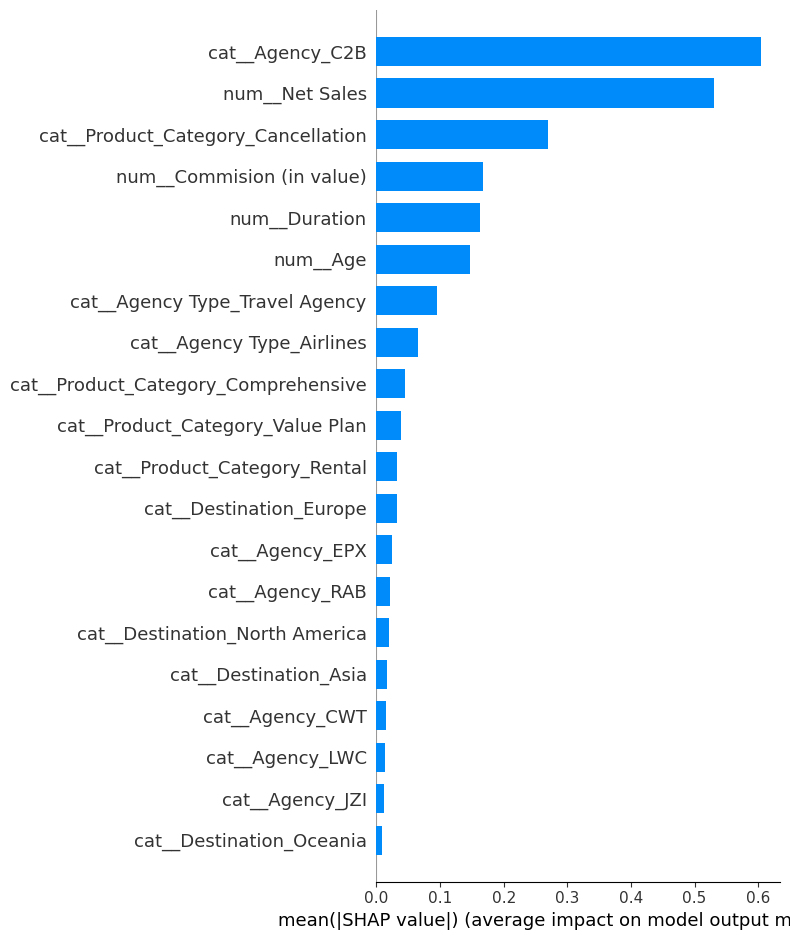

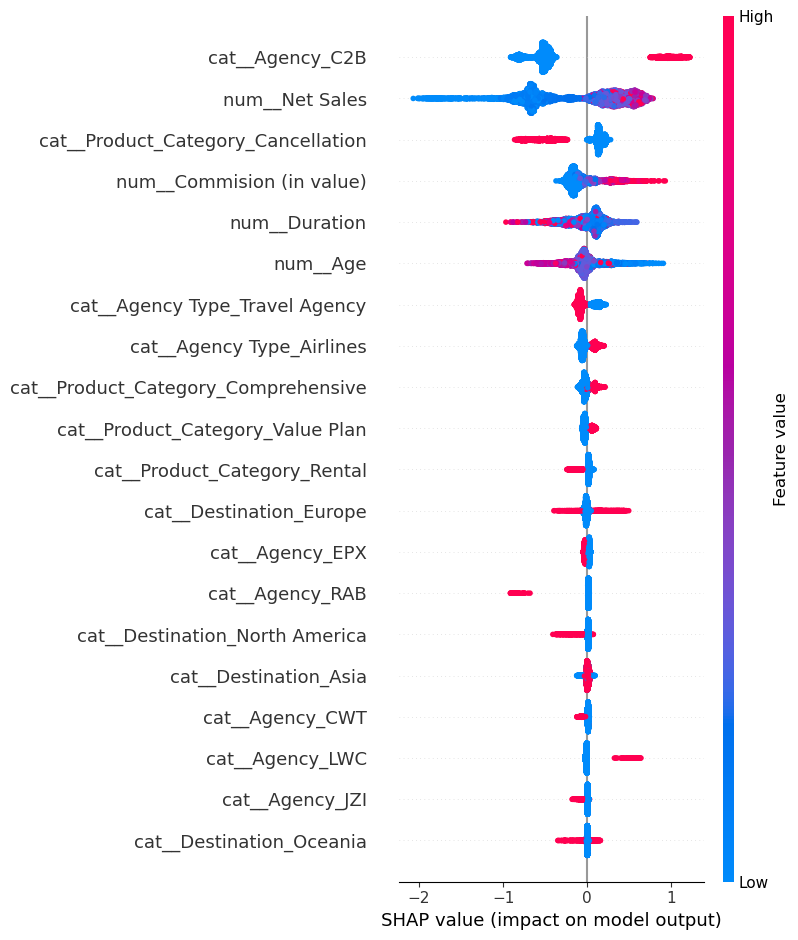

In [ ]:
cat_model = best_cat_rus.named_steps['model']
preprocessor = best_cat_rus.named_steps['preprocessor']


X_test_proc = preprocessor.transform(X_test)
feature_names = preprocessor.get_feature_names_out()


explainer = shap.TreeExplainer(cat_model)
shap_values = explainer.shap_values(X_test_proc)


shap.summary_plot(
    shap_values, 
    X_test_proc, 
    feature_names=feature_names, 
    plot_type="bar",
    show=True
)


shap.summary_plot(
    shap_values, 
    X_test_proc, 
    feature_names=feature_names,
    show=True
)


try:
    idx = np.where((y_test.values == 1) & (y_pred_test == 1))[0][0]
except:
    idx = 0  # fallback

shap.initjs()
shap.force_plot(
    explainer.expected_value,
    shap_values[idx, :],
    feature_names=feature_names
)


In [ ]:
print("=== Cost–Benefit Analysis (CatBoost + RUS) ===")


y_prob = best_cat_rus.predict_proba(X_test)[:, 1]
y_pred = (y_prob >= 0.5).astype(int)


cm = confusion_matrix(y_test, y_pred)
TN, FP, FN, TP = cm.ravel()

print("\nConfusion Matrix:")
print(cm)
print(f"\nTN: {TN}, FP: {FP}, FN: {FN}, TP: {TP}")



cost_FN = 2000   # Asumsi biaya bila claimant tidak terdeteksi
cost_FP = 50     # Asumsi biaya yang dikeluarkan bila salah tandai non-claimant sebagai claimant
benefit_TP = 2000   # Keuntungan bila claimant terdeteksi
benefit_TN = 0      # Keuntungan bila non-claimant terdeteksi



total_benefit = (TP * benefit_TP) + (TN * benefit_TN)
total_cost    = (FN * cost_FN) + (FP * cost_FP)
net_impact    = total_benefit - total_cost

print("\n=== BUSINESS IMPACT ===")
print(f"Total Benefit : {total_benefit:,.0f}")
print(f"Total Cost    : {total_cost:,.0f}")
print(f"Net Impact    : {net_impact:,.0f}")

if net_impact > 0:
    print("Conclusion: Model memberikan nilai bisnis (bermanfaat)")



=== Cost–Benefit Analysis (CatBoost + RUS) ===

Confusion Matrix:
[[5900 1635]
 [  21   96]]

TN: 5900, FP: 1635, FN: 21, TP: 96

=== BUSINESS IMPACT ===
Total Benefit : 192,000
Total Cost    : 123,750
Net Impact    : 68,250

Conclusion:  Model memberikan nilai bisnis (bermanfaat).


### Recommendation

Rekomendasi Data:
1. Perbanyak jumlah claimant agar model belajar lebih optimal mengenali pola claimant.  
2. Perbanyak fitur terkait kehidupan (behaviour) customer, ini tentu dapat menangkap pola perilaku
3. Tambah data mengenai agensi. menarik karena agensi menjadi salah satu faktor dominan yang mendorong klaim.  

Rekomendasi Model:
1. Dalam proses pengerjaan, saya menemukan banyak teknik menangani imbalance yang dapat dicoba. Bila ada waktu, alangkah baiknya mencoba berbagai teknik imbalance dan model yang berbeda untuk mendapatkan skor yang optimal.
2. Berkaitan dengan fitur, sepertinya diperlukan fitur engineering untuk mendapatkan pola-pola yang lebih rigid (fitur yang model ini pakai masih fitur dasar)  
3. Bila mampu, training menggunakan gridsearch untuk mencari komposisi hyperparameter yang lebih optimal.  

Rekomendasi Bisnis:  
1. Gunakan model ini untuk mengidentifikasi potential claimants sejak awal. Dengan demikian, perusahaan dapat melakukan langkah proaktif seperti penyesuaian premi atau pengecekan ulang terhadap kustomer yang teridentifikasi beresiko tinggi.  
2. Lakukan review terhadap agensi yang memiliki tingkat klaim tinggi berdasarkan data historis. Hal ini dapat membantu dalam mengelola resiko dan meningkatkan kualitas layanan agen.  
3. Buat flagging untuk highrisk customer.  

### Pickle

In [59]:
best_cat_rus.fit(X, y)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median'))]),
                                                  ['Duration', 'Net Sales',
                                                   'Commision (in value)',
                                                   'Age']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['Agency', 'Agency Type',
                                                   'Distribution Channel',
                                                   'Destination',
                                                   'Product_Category'])])),
                ('sampler', RandomUnderSampler(random_state=42)),
                ('model',
                 <catboost.core.CatBoostClassifier object at 0x000002692D3CBEF0>)])

In [ ]:
#pickle.dump(best_cat_rus, open('model_travel_insurance_catboost.sav','wb'))

In [58]:
model_load=pickle.load(open('model_travel_insurance_catboost.sav','rb'))
model_load

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median'))]),
                                                  ['Duration', 'Net Sales',
                                                   'Commision (in value)',
                                                   'Age']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['Agency', 'Agency Type',
                                                   'Distribution Channel',
                                                   'Destination',
                                                   'Product_Category'])])),
                ('sampler', RandomUnderSampler(random_state=42)),
                ('model',
                 <catboost.core.CatBoostClassifier object at 0x0000026933A8F710>)])

In [68]:
cust1 = df_cleaned.iloc[[1], :]
cust8 = df_cleaned.iloc[[8], :]

pred1 = model_load.predict(cust1)
pred8 = model_load.predict(cust8)

prob1 = model_load.predict_proba(cust1)
prob8 = model_load.predict_proba(cust8)
print("Customer 1  Pred:", pred1, " Prob:", prob1)
print("Customer 8  Pred:", pred8, " Prob:", prob8)

Customer 1  Pred: [0]  Prob: [[0.91899659 0.08100341]]
Customer 8  Pred: [0]  Prob: [[0.75546497 0.24453503]]


In [69]:
print("Actual y0:", y.iloc[0])
print("Actual y1:", y.iloc[1])

Actual y0: 0
Actual y1: 0


In [ ]:


y_pred = model_load.predict(X_test)
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[[5632 1903]
 [  31   86]]
              precision    recall  f1-score   support

           0       0.99      0.75      0.85      7535
           1       0.04      0.74      0.08       117

    accuracy                           0.75      7652
   macro avg       0.52      0.74      0.47      7652
weighted avg       0.98      0.75      0.84      7652

